## Experiment Setup

In [1]:
# Import Statements / Setup
from Dataset import Dataset
import matplotlib.pyplot as plt
import numpy as np
from preprocess_data import filter_genres
import sklearn
import tensorflow as tf
import time

from models.Model import Model
from models.CNNModel import CNNModel
from models.LogisticRegression import LogisticRegression


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def current_time_millis():
    return int(round(time.time() * 1000))

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Load / Preprocess Data

In [2]:
np.random.seed(123456789) # Make ordering of data consistent b/w runs

# List of all genres
ALL_GENRES_LIST = [
    'Action', 'Adventure', 'Animation', 'Comedy',
    'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
    'History', 'Horror', 'Music', 'Mystery', 'Romance',
    'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western'
]

# List of genres which we will attempt to classify.
#USED_GENRES_LIST = [
#    'Action', 'Comedy'
#]
USED_GENRES_LIST = ALL_GENRES_LIST

# Load and Shuffle Data.
start_time = current_time_millis()
posters = np.load('movie_data/posters.npy')
genres = np.load('movie_data/genres.npy')
posters, genres = sklearn.utils.shuffle(posters, genres)
end_time = current_time_millis()
print('Loading Data took {0} seconds\n'.format((end_time-start_time)/1000.0))

# Remove genres which we are not attempting to classify
genres = filter_genres(ALL_GENRES_LIST, USED_GENRES_LIST, genres)
label_probabilities = np.mean(genres, axis=0, keepdims=True)
print('Fraction of examples which belong to genre:')
for i, genre in enumerate(USED_GENRES_LIST):
    print('{0} : {1:.2f}'.format(genre, label_probabilities[0][i]))

Loading Data took 39.072 seconds

Fraction of examples which belong to genre:
Action : 0.18
Adventure : 0.10
Animation : 0.07
Comedy : 0.33
Crime : 0.11
Documentary : 0.05
Drama : 0.44
Family : 0.08
Fantasy : 0.07
History : 0.03
Horror : 0.14
Music : 0.03
Mystery : 0.06
Romance : 0.15
Science Fiction : 0.08
TV Movie : 0.02
Thriller : 0.20
War : 0.03
Western : 0.02


## Initializing Train / Validation / Test Datasets

In [3]:
# TRAIN/VALID/TEST SPLIT = 75/15/10
TRAIN_SPLIT = int(np.ceil(len(posters) * 0.75))
VALID_SPLIT = TRAIN_SPLIT + int(np.ceil(len(posters) * 0.15))

train_dataset = Dataset(posters[:TRAIN_SPLIT], genres[:TRAIN_SPLIT])
train_mean, train_std = train_dataset.get_original_mean_and_std()

valid_dataset = Dataset(
    posters[TRAIN_SPLIT:VALID_SPLIT],
    genres[TRAIN_SPLIT:VALID_SPLIT],
    mean = train_mean,
    std = train_std
)

test_dataset = Dataset(
    posters[VALID_SPLIT:],
    genres[VALID_SPLIT:],
    mean = train_mean,
    std = train_std
)

print('Total Number of Examples: {0}'.format(len(posters)))
print('Number of Train/Valid/Test Examples: {0}/{1}/{2}'.format(
    train_dataset.size(),
    valid_dataset.size(),
    test_dataset.size()
))
print('Image Size: {0}'.format(posters.shape[1:]))
print('Number of Genres: {0}'.format(genres.shape[1]))

Total Number of Examples: 29588
Number of Train/Valid/Test Examples: 22191/4439/2958
Image Size: (278, 185, 3)
Number of Genres: 19


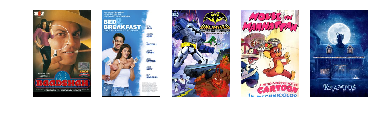

In [4]:
rows, columns = 1, 5
fig = plt.figure()
for i in range(1, rows*columns+1):
    fig.add_subplot(rows, columns, i)
    image = train_dataset.X[i-1] * train_std + train_mean
    plt.imshow(image.astype(np.uint8))
    plt.axis('off')

## Baseline Model (Logistic Regression)

In [4]:
# Free up memory from previous run(s)
if 'model' in vars() or 'model' in globals():
    del model
    tf.reset_default_graph()

model = LogisticRegression(
    USED_GENRES_LIST,
    label_probabilities,
    train_dataset.X.shape[1:]
)

model.train(
    train_dataset,
    valid_dataset,
    num_epochs = 10,
    verbose=True
)

Initializing model...

KeyboardInterrupt: 

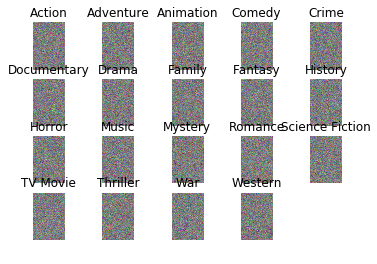

In [8]:
W = model.get_weights()
W = np.reshape(W, (278, 185, 3, len(USED_GENRES_LIST)))

W_min, W_max = np.min(W), np.max(W)
for i in range(len(USED_GENRES_LIST)):
    plt.subplot(4, 5, i + 1)
    # Rescale the weights to be between 0 and 255
    W_img = 255.0 * (W[:, :, :, i].squeeze() - W_min) / (W_max - W_min)
    plt.imshow(W_img.astype('uint8'))
    plt.axis('off')
    plt.title(USED_GENRES_LIST[i])

## CNN Model

In [51]:
# Free up memory from previous run(s)
if 'model' in vars() or 'model' in globals():
    del model
    tf.reset_default_graph()

model = CNNModel(
    USED_GENRES_LIST,
    label_probabilities,
    posters.shape[1:]
)

model.train(
    train_dataset,
    valid_dataset,
    num_epochs = 10,
    batch_size = 100,
    eta = 1e-4,
    saving = False,
    verbose = True,
)

Initializing model...Done.
Training Model...
Epoch #1 out of 10: 
222/222 [==============================] - 22s - Train Loss: 1.6253    
Validation Loss: 1.4114 *


/home/shared/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/shared/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


------------------------------------------------------------
|      Genre      | Accuracy | Precision | Recall |   F1   |
------------------------------------------------------------
| Action          |  0.7846  |   0.0000  | 0.0000 | 0.0000 |
| Adventure       |  0.8795  |   0.0000  | 0.0000 | 0.0000 |
| Animation       |  0.3985  |   0.0829  | 0.8345 | 0.1508 |
| Comedy          |  0.4879  |   0.3231  | 0.5442 | 0.4054 |
| Crime           |  0.1347  |   0.1347  | 1.0000 | 0.2374 |
| Documentary     |  0.9417  |   0.0000  | 0.0000 | 0.0000 |
| Drama           |  0.4758  |   0.4758  | 1.0000 | 0.6448 |
| Family          |  0.3370  |   0.0818  | 0.8840 | 0.1497 |
| Fantasy         |  0.0608  |   0.0608  | 1.0000 | 0.1147 |
| History         |  0.0351  |   0.0210  | 1.0000 | 0.0412 |
| Horror          |  0.8725  |   0.0000  | 0.0000 | 0.0000 |
| Music           |  0.0297  |   0.0297  | 1.0000 | 0.0578 |
| Mystery         |  0.0590  |   0.0590  | 1.0000 | 0.1115 |
| Romance         |  0.1

222/222 [==============================] - 21s - Train Loss: 1.4387    
Validation Loss: 1.4328 
------------------------------------------------------------
|      Genre      | Accuracy | Precision | Recall |   F1   |
------------------------------------------------------------
| Action          |  0.7047  |   0.1986  | 0.1224 | 0.1515 |
| Adventure       |  0.8790  |   0.3750  | 0.0056 | 0.0110 |
| Animation       |  0.8241  |   0.0906  | 0.1937 | 0.1235 |
| Comedy          |  0.3573  |   0.3234  | 0.9192 | 0.4785 |
| Crime           |  0.1352  |   0.1348  | 1.0000 | 0.2375 |
| Documentary     |  0.6745  |   0.0264  | 0.1504 | 0.0449 |
| Drama           |  0.4846  |   0.4793  | 0.9659 | 0.6407 |
| Family          |  0.8844  |   0.0455  | 0.0375 | 0.0411 |
| Fantasy         |  0.4587  |   0.0573  | 0.5111 | 0.1030 |
| History         |  0.0948  |   0.0224  | 1.0000 | 0.0438 |
| Horror          |  0.7148  |   0.1759  | 0.3357 | 0.2309 |
| Music           |  0.2318  |   0.0373  | 1.0000

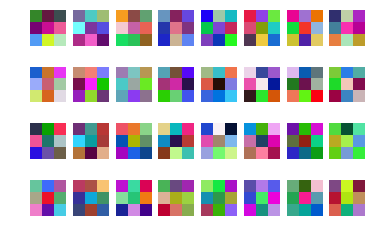

In [39]:
graph = tf.get_default_graph()

#for n in graph.as_graph_def().node:
#    print(n.name)

W = graph.get_tensor_by_name('conv2d/kernel:0').eval(session=model.session)

W_min, W_max = np.min(W), np.max(W)
for i in range(W.shape[-1]):
    plt.subplot(4, 8, i + 1)
    # Rescale the weights to be between 0 and 255
    W_img = 255.0 * (W[:, :, :, i].squeeze() - W_min) / (W_max - W_min)
    plt.imshow(W_img.astype('uint8'))
    plt.axis('off')
